# Getting started with spike-field coherence

## On-ramp: compute the spike-field cohernece


Run the code below to load in spike and field data, and compute the spike-field coherence.

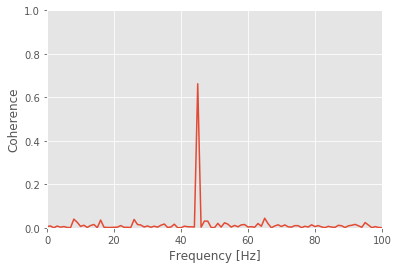

In [3]:
import scipy as scp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#matplotlib tk

# Load the data and plot it.
data = scp.io.loadmat('spikes-LFP-1.mat')       # Load the multiscale data,
y = data['y']                                # ... get the LFP data,
n = data['n']                                # ... get the spike data,
t = data['t'].reshape(-1)                    # ... get the time axis,
K = np.shape(n)[0]                           # Get the number of trials,
N = np.shape(n)[1]                           # ... and the number of data points in each trial,
dt = t[1]-t[0]                               # Get the sampling interval.

SYY = np.zeros(int(N/2+1))                                       # Variable to store field spectrum.
SNN = np.zeros(int(N/2+1))                                       # Variable to store spike spectrum.
SYN = np.zeros(int(N/2+1), dtype=complex)                        # Variable to store cross spectrum.

for k in np.arange(K):                                           # For each trial,
    yf = np.fft.rfft((y[k,:]-np.mean(y[k,:])) *np.hanning(N))    # Hanning taper the field,
    nf = np.fft.rfft((n[k,:]-np.mean(n[k,:])))                   # ... but do not taper the spikes.
    SYY = SYY + ( np.real( yf*np.conj(yf) ) )/K                  # Field spectrum
    SNN = SNN + ( np.real( nf*np.conj(nf) ) )/K                  # Spike spectrum
    SYN = SYN + (          yf*np.conj(nf)   )/K                  # Cross spectrum

cohr = np.real(SYN*np.conj(SYN)) / SYY / SNN                     # Spike-field coherence
f = np.fft.rfftfreq(N, dt)                                       # Frequency axis for plotting

plt.plot(f,cohr)                             # Plot the result.
plt.xlim([0, 100])
plt.ylim([0, 1])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Coherence');

***

# Dependence on rate (Part 1)

In [ ]:
# Load modules we'll need.
import scipy.io as sio
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

### For convenience, make a function to compute the cohernece.

In [ ]:
def coherence(n,y,t):                           #INPUT (spikes, fields, time)
    K = np.shape(n)[0]                          #... where spikes and fields are arrays [trials, time]
    N = np.shape(n)[1]
    T = t[-1]
    SYY = np.zeros(int(N/2+1))
    SNN = np.zeros(int(N/2+1))
    SYN = np.zeros(int(N/2+1), dtype=complex)
    
    for k in np.arange(K):
        yf = np.fft.rfft((y[k,:]-np.mean(y[k,:])) *np.hanning(N))    # Hanning taper the field,
        nf = np.fft.rfft((n[k,:]-np.mean(n[k,:])))                   # ... but do not taper the spikes.
        SYY = SYY + ( np.real( yf*np.conj(yf) ) )/K                  # Field spectrum
        SNN = SNN + ( np.real( nf*np.conj(nf) ) )/K                  # Spike spectrum
        SYN = SYN + (          yf*np.conj(nf)   )/K                  # Cross spectrum

    cohr = np.real(SYN*np.conj(SYN)) / SYY / SNN                     # Coherence
    f = np.fft.rfftfreq(N, dt)                                       # Frequency axis for plotting
    
    return (cohr, f, SYY, SNN, SYN)

Let's try it:

In [ ]:
[cohr, f, SYY, SNN, SYN] = coherence(n,y,t)
plt.plot(f,cohr)
plt.xlim([0, 100]); xlabel('Frequency [Hz]'); ylabel('Coherence');

### Make a function to thin a spike train.

In [ ]:
def thinned_spike_train(n, thinning_factor):              # Thin the spike train (n) by the thinning_factor.
    n_thinned = np.copy(n)                                # Make a copy of the spike train data.
    for k in np.arange(K):                                # For each trial,
        spike_times = np.where(n[k,:]==1)                 # ...find the spikes.
        n_spikes = np.size(spike_times)                   # ...determine number of spikes.
        spike_times_random = spike_times[0][np.random.permutation(n_spikes)]    # ...permute spikes indices,
        n_remove=int(np.floor(thinning_factor*n_spikes))  # ... determine number of spikes to remove,
        n_thinned[k,spike_times_random[1:n_remove]]=0     # remove the spikes.
    return n_thinned

Let's try it:

In [ ]:
plt.clf()
plt.plot(t, n[0,:], 'k')
plt.plot(t, thinned_spike_train(n,0.5)[0,:], 'r');
plt.xlim([0.2, 0.3])
plt.legend(['Original', 'Thinned']);

### Compare the spike-field coherence for original and thinned data.

In [ ]:
[cohr, f, SYY, SNN, SYN] = coherence(n,y,t)                          # Plot the coherence for original spike train.
plt.clf()
plt.plot(f,cohr, 'b')
[cohr, f, SYY, SNN, SYN] = coherence(thinned_spike_train(n,0.5),y,t) # ... and for the thinned spike train.
plt.plot(f,cohr, 'r')
plt.xlim([40, 50])
plt.legend(['Original', 'Thinned'])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Coherence');

### Q: At what phases are the spikes removed?

Make a function to compute field phase:

In [ ]:
def get_field_phase(y):
    phi = np.zeros([K,N])
    for k in np.arange(K):                               # For each trial,
        phi[k,:] = np.angle(signal.hilbert(y[k,:]))      #  ... compute phase of the field
    return phi

Compute field phase at each spike removed:

In [ ]:
phi                     = get_field_phase(y)
spikes_removed          = n - thinned_spike_train(n,0.5)
phase_at_spikes_removed = phi[spikes_removed == 1]
plt.clf()
plt.hist(phase_at_spikes_removed);
plt.xlabel('Phase')
plt.ylabel('Counts');

***

# Dependence on rate (Part 2)

### Simulate two simple spiking neurons, with activity dependent on a field.

In [ ]:
n = np.zeros([K,N])                # Array to hold spikes #1.
m = np.zeros([K,N])                # Array to hold spikes #2.
y = np.zeros([K,N])                # Array to hold field.
for k in np.arange(K):             # For each trial,
    y[k,:] = np.sin(2*np.pi*t*10) + 0.1*np.random.randn(N)    # ... generate a field,
    n[k,:] = np.random.binomial(1,0.001*exp(0+2*y[k,:]))        # ... generate spikes #1 that depend on the field,
    m[k,:] = np.random.binomial(1,0.001*exp(3+1*y[k,:]))        # ... generate spikes #2 that depend on the field.

### Visualize example trials.

In [ ]:
plt.clf()
n_trial = 0;
plt.plot(t,n[n_trial,:])
plt.plot(t,m[n_trial,:])
plt.plot(t,y[n_trial,:])
plt.legend(["Neuron #1", "Neuron #2", "Field"]);

### Compute the average rate of each neuron

In [ ]:
rate1 = mean(sum(n,1)/t[-1])
rate2 = mean(sum(m,1)/t[-1])

print("n(Rate1) = ", rate1, ", m(Rate2) = ", rate2)

### Compute the spike-field coherence.

In [ ]:
plt.clf()

[cohr, f, SYY, SNN, SYN] = coherence(n,y,t)
plt.plot(f,cohr)

[cohr, f, SYY, SNN, SYN] = coherence(m,y,t)
plt.plot(f,cohr)

plt.xlim([0,20])
plt.legend(['Neuron #1', 'Neuron #2'])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Coherence');

### Examine the LFP phase at each spike.

In [ ]:
phi               = get_field_phase(y)
phase_at_spikes_1 = phi[n == 1]
phase_at_spikes_2 = phi[m == 1]

plt.clf()
plt.hist([phase_at_spikes_1,phase_at_spikes_2],density=True,);
plt.xlabel('Phase')
plt.ylabel('Counts')
plt.legend(['Neuron #1', 'Neuron #2']);